He hecho las cosas de forma mas manual por dos razones principales:

1. En MLM permitir si solo queremos masquear los tokens de la descripcion "true" o si tambien queremos masquar tokens de la descripcion "false"
2. En las tareas de imagen y multimodales, permitir aplicar nuestras propias transformaciones al dato.
   1. Tecnicamente en este caso no es necesario porque estamos forzados a normalizar la imagen con el processor, pero bueno, nos da mas control sobre el proceso.

In [12]:
import PIL.Image
import torch

from huggingface_hub import login
from datasets import load_dataset
from transformers import (
    DataCollatorForLanguageModeling, 
    AutoTokenizer,
    AutoImageProcessor,
    FlavaProcessor,
    FlavaForPreTraining,
    FlavaImageCodebook,
    FlavaImageProcessor,
)
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    RandomApply,
    RandomRotation,
    Resize,
    ToTensor,
)

In [2]:
login()

/anaconda/envs/transformers/lib/python3.9/site-packages/datasets/load.py:2072: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=True' instead.
  warnings.warn(


A child holding a flowered umbrella and petting a yak.


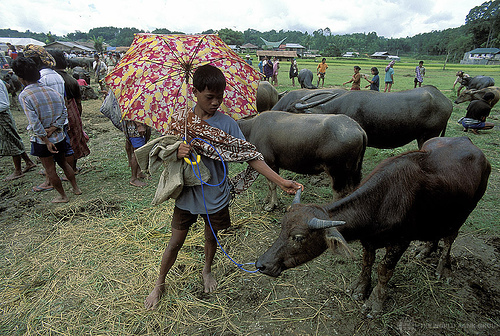

In [3]:
dset = load_dataset("facebook/pmd", "coco", use_auth_token=True, streaming=True)

iterator = iter(dset['validation'])
instance = next(iterator)

print (instance["text"])
instance["image"]

In [8]:
model_name = "facebook/flava-full"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# image_processor = AutoImageProcessor.from_pretrained(model_name)
# image_codebook = FlavaImageCodebook.from_pretrained(model_name)

description_true = instance["text"]
description_false = "A sunflower in a green field under the rain"
image = instance["image"]

### Preparar MLM

1. Tokenizamos el texto combinado (`description_true` y `description_false`)
   1. `tokenizer([("ejemplo #1 (verdadero)", "ejemplo #1 (false)"), "ejemplo #2"])` # hay que pasarle tuplas cuando queremos multiples descripciones combinadas
2. Usamos el `DataCollatorForLanguageModeling` para maskear los tokens
3. Extra: Aplicamos una mascara sobre los tokens de la `description_false` para que no sean considerados en MLM (es realmente necesario?)

-----

Nota: El resultado es un diccionario de tensores, del cual mas adelante podemos extrar los valores para los diferentes entrenamientos.

----

In [120]:
# 1 - Tokenizamos el texto combinado de "description_true" y "description_false"
description_pairs = [
    (description_true, description_false), 
    # ("borrar", "borrar 2") # Ejemplo para ver como quedaria el encoded_dict del data_collator si le paso varios valores
]
description_pairs_tokenized = []
for description_pair in description_pairs:
    text_tokenized = tokenizer(description_pair[0], description_pair[1])
    description_pairs_tokenized.append(text_tokenized)
    text_decoded = tokenizer.decode(text_tokenized["input_ids"]) # primer item
    print(text_decoded)
    print(text_tokenized["token_type_ids"])

# 2 - Usamos el DataCollatorForLanguageModeling para maskear los tokens (ignora automaticamente [CLS] y [SEP])
# Nota: Espera una lista de diccionarios, cada uno correspondiente a una instancia tokenizada
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,  # Whether to use masked language modeling objective
    mlm_probability=0.8  # Probability of masking a token for MLM
)
text_inputs = data_collator(description_pairs_tokenized)

# 3 (extra) - Aplicamos una mascara sobre los tokens de la segunda descripcion para que no sean considerados en MLM
# Para ello, usamos la informacion en token_type_ids, ponemos con -100 en labels aquellos tokens que tengan el valor 1 en token_type_ids

# Explicacion: Si la máscara es 1, obtenemos el valor original multiplicado por 0 (que es 0) menos 100. Si la máscara es 0, 
# obtenemos el valor original multiplicado por 1 (que es el valor original) menos 0. En resumen, se aplica -100 a los lugares 
# donde la máscara es 1 y se mantiene el valor original donde la máscara es 0
text_inputs["labels"] = text_inputs["labels"] * (1 - text_inputs["token_type_ids"]) - 100 * text_inputs["token_type_ids"]

# 4 - Renombrar labels a "input_ids_masked" que es lo que espera el modelo
text_inputs["input_ids_masked"] = text_inputs["labels"]
del text_inputs["labels"]

[CLS] a child holding a flowered umbrella and petting a yak. [SEP] a sunflower in a green field under the rain [SEP]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [121]:
text_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'input_ids_masked'])

### Preparar MIM

FLAVA tiene su propio ImageProcessor que es necesario para poder generar os image tokens que se usaran en la tarea de MIM. Estos labels estan basados en el "vocabulario" de DALL-E. 

Este ImageProcessor contiene a su vez la posibilidad de hacer transformaciones sobre la imagen, pero para evitar transformaciones que no encajen con lo que queremos, vamos a transformar la imagen manualmente y le vamos a pasar al modelo la imagen en forma de tensor. El porque hacemos esto es porque las transformaciones que hace flava como crops y demas pueden no encajar en lo que tenemos en mente para nuestro dominio particular. **Solo nos interesa que genere la mascara y los labels para la tarea de MIM.**

-----

**Nota:** Si queremos normalizar hay que hacerlo en el image processor porque si lo hacemos antes no podemos devolver los codebook pixels, los cuales son necesarios 

-----

In [137]:
# Since we are forced to use the FlavaImageProcessor for generating the MIM labels,
# we are going to put all image transformations to False. Our idea is to do our own transformations.
image_processor = FlavaImageProcessor(
    do_resize=False,
    do_center_crop=False,
    do_rescale=False,
    do_normalize=True, # Obligatorio si queremos normalizar, no podemos aplicarlo en las transformaciones anteriores
    return_image_mask=True, # necessary for MIM
    return_codebook_pixels=True, # necessary for MIM
)

image_mean = image_processor.image_mean
image_std = image_processor.image_std
size = image_processor.size[list(image_processor.size.keys())[0]]

image_transforms = Compose(
            [
                # RandomResizedCrop(size=size, scale=(0.4, 1.0)),
                # RandomApply(
                #     torch.nn.ModuleList([RandomRotation(degrees=(180, 180))]),
                #     p=0.1,
                # ),
                Resize((size, size)),
                ToTensor(),
                # Normalize(mean=image_mean, std=image_std), # No podemos normalizar antes de pasarle la imagen
            ]
        )

images = [image]

transformed_images = [
    image_transforms(image) for image in images
]
pixel_values = torch.stack(transformed_images, dim=0)

Vamos a comprobar que realmente el imageProcessor no hace ningun tipo de transformacion extra sobre el dato

In [148]:
image_inputs = image_processor(pixel_values)

# Si los valores son listas los convertimos en tensores (creo que solo pasa cuando consideramos una única imagen)
if isinstance(image_inputs["pixel_values"], list):
    image_inputs["pixel_values"] = torch.tensor(image_inputs["pixel_values"])
if isinstance(image_inputs["codebook_pixel_values"], list):
    image_inputs["codebook_pixel_values"] = torch.tensor(image_inputs["codebook_pixel_values"])
if isinstance(image_inputs["bool_masked_pos"], list):
    image_inputs["bool_masked_pos"] = torch.tensor(image_inputs["bool_masked_pos"])

torch.equal(pixel_values, image_inputs["pixel_values"]) # Da False si normalizamos por el image processor y no por la image_transformations, pero seria la unica diferencia

False

In [149]:
image_inputs.keys()

dict_keys(['pixel_values', 'codebook_pixel_values', 'bool_masked_pos'])

### Probar como funciona el modelo cuando le pasamos "toda" la informacion

El objetivo es ver que tareas realiza, para comprobar si tenemos toda la informacion necesaria

In [150]:
model = FlavaForPreTraining.from_pretrained(model_name)

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.


In [151]:
print(image_inputs.keys())
print(text_inputs.keys())

print(len(text_inputs["input_ids"]))
print(len(text_inputs["token_type_ids"]))
print(len(text_inputs["attention_mask"]))
print(len(text_inputs["input_ids_masked"]))
print(len(image_inputs["pixel_values"]))
print(len(image_inputs["codebook_pixel_values"]))
print(len(image_inputs["bool_masked_pos"]))

dict_keys(['pixel_values', 'codebook_pixel_values', 'bool_masked_pos'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'input_ids_masked'])
1
1
1
1
1
1
1


In [152]:
def combine_dicts(dict1, dict2):
    if any(len(val1) != len(val2) for val1, val2 in zip(dict1.values(), dict2.values())):
        raise ValueError("All values in both dictionaries must have the same length.")

    common_keys = set(dict1.keys()) & set(dict2.keys())
    if common_keys:
        raise ValueError(f"Common keys found: {common_keys}. Dictionaries cannot have the same keys.")

    combined_dict = {**dict1, **dict2}
    return combined_dict

combined_inputs = combine_dicts(text_inputs, image_inputs)

combined_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'input_ids_masked', 'pixel_values', 'codebook_pixel_values', 'bool_masked_pos'])

In [153]:
combined_inputs["input_ids"]

tensor([[  101,  1037, 26325,   103,   103,   103,   103,   103,  1998,   103,
         11102,   103,   103,   103,  1012,   102,   103, 21891,   103,   103,
           103,   103,  2492,   103,  2067,   103,   102]])

In [157]:
# for key, value in combined_inputs.items():
#     print(f'Type of {key}: {type(value)}')
for key, value in combined_inputs.items():
    print(f'Type of {key}: {value.shape}')

Type of input_ids: torch.Size([1, 27])
Type of token_type_ids: torch.Size([1, 27])
Type of attention_mask: torch.Size([1, 27])
Type of input_ids_masked: torch.Size([1, 27])
Type of pixel_values: torch.Size([1, 3, 224, 224])
Type of codebook_pixel_values: torch.Size([1, 3, 112, 112])
Type of bool_masked_pos: torch.Size([1, 14, 14])


Me da problemas con la MLM loss, pero cuando quito el input_ids_masked no calcula la MLM. Quizas no la estoy ajustando bien...

El warning si no lo paso:

`input_ids_masked` isn't passed which means MLM loss won't be calculated correctlySetting it to `input_ids` so that model can work. Please pass it if this is unintentional. This is usually OKAY if you are doing inference on unmasked text...

In [161]:
test_inputs = {}
test_inputs["input_ids"] = combined_inputs["input_ids"]
test_inputs["token_type_ids"] = combined_inputs["token_type_ids"]
test_inputs["attention_mask"] = combined_inputs["attention_mask"]
# test_inputs["input_ids_masked"] = combined_inputs["input_ids_masked"]
test_inputs["pixel_values"] = combined_inputs["pixel_values"]
test_inputs["codebook_pixel_values"] = combined_inputs["codebook_pixel_values"]
test_inputs["bool_masked_pos"] = combined_inputs["bool_masked_pos"]

outputs = model(**test_inputs)

`input_ids_masked` isn't passed which means MLM loss won't be calculated correctlySetting it to `input_ids` so that model can work. Please pass it if this is unintentional. This is usually OKAY if you are doing inference on unmasked text...
/anaconda/envs/transformers/lib/python3.9/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [162]:
outputs

FlavaForPreTrainingOutput(loss=tensor(10.2182, grad_fn=<AddBackward0>), loss_info=FlavaLosses(mim=None, mlm=None, itm=None, global_contrastive=tensor(0., grad_fn=<MulBackward0>), mmm_image=tensor(10.2182, grad_fn=<MulBackward0>), mmm_text=None), image_embeddings=tensor([[[-0.0186,  0.0896, -0.0231,  ..., -0.0330,  0.0193,  0.1173],
         [-0.0626,  0.0960,  0.0169,  ..., -0.0315,  0.0744,  0.0123],
         [-0.0429,  0.0939,  0.0121,  ..., -0.0457,  0.0316,  0.0361],
         ...,
         [-0.0249, -0.0805,  0.1267,  ..., -0.1087,  0.0519,  0.0337],
         [ 0.0255, -0.0684,  0.1032,  ..., -0.0544,  0.0339,  0.0568],
         [-0.0108, -0.0258,  0.0753,  ..., -0.0269,  0.0959,  0.0189]]],
       grad_fn=<NativeLayerNormBackward0>), image_output=BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.0186,  0.0896, -0.0231,  ..., -0.0330,  0.0193,  0.1173],
         [-0.0626,  0.0960,  0.0169,  ..., -0.0315,  0.0744,  0.0123],
         [-0.0429,  0.0939,  0.0121,  ..., -0.0457,